In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [10]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


In [11]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_post', 'host', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)]]


In [17]:
id2word[0]

'addition'

In [18]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('maryland_college', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_post', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('specs', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [20]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.238*"window" + 0.099*"driver" + 0.031*"win" + 0.025*"professional" + '
  '0.023*"ohio_state" + 0.023*"rd" + 0.017*"microsoft" + '
  '0.016*"window_manager" + 0.015*"dos" + 0.014*"button"'),
 (1,
  '0.038*"card" + 0.034*"mail" + 0.026*"computer" + 0.025*"run" + '
  '0.025*"system" + 0.023*"software" + 0.023*"email" + 0.023*"sale" + '
  '0.020*"info" + 0.018*"thank"'),
 (2,
  '0.120*"file" + 0.046*"machine" + 0.043*"copy" + 0.041*"disk" + '
  '0.039*"peter" + 0.028*"bus" + 0.023*"case_western" + '
  '0.023*"reserve_university" + 0.022*"msg" + 0.016*"wide"'),
 (3,
  '0.019*"space" + 0.018*"information" + 0.016*"use" + 0.013*"include" + '
  '0.012*"also" + 0.012*"program" + 0.012*"system" + 0.012*"new" + '
  '0.011*"available" + 0.010*"provide"'),
 (4,
  '0.133*"bike" + 0.057*"ride" + 0.047*"motorcycle" + 0.021*"rid" + '
  '0.016*"rider" + 0.012*"safely" + 0.012*"steer" + 0.012*"riding" + '
  '0.009*"countersteere" + 0.006*"biker"'),
 (5,
  '0.836*"ax" + 0.059*"max" + 0.008*"mac"

In [21]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.708910121024964

Coherence Score:  0.47647829731491387


In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      32.189713        1       1 -0.385547  0.078051
10     19.200752        1       2 -0.350106  0.101430
9      15.255292        1       3 -0.360145  0.092653
3      11.370051        1       4 -0.292970 -0.005133
1       4.885111        1       5 -0.134186 -0.112063
5       4.860707        1       6 -0.073932 -0.445851
11      3.132899        1       7 -0.094854 -0.013918
7       1.494445        1       8  0.071710 -0.020800
2       1.288575        1       9  0.092994  0.003524
12      1.038364        1      10  0.079892 -0.004969
13      0.783060        1      11  0.108024  0.009913
16      0.764769        1      12  0.129941  0.025484
15      0.640055        1      13  0.129682  0.024097
0       0.635212        1      14  0.135323  0.032476
18      0.599443        1      15  0.140558  0.033070
17      0.532305        1      16  0.143961  0.030348
14      0.512460        1      17  0.137397  0.031742
8       0.460500        1      18  0.164193  0.042244
4       0.179447        1      19  0.178099  0.048454
19      0.176830        1      20  0.179967  0.049247, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
4104   Default  64360.000000            ax  64360.000000  30.0000  30.0000
21     Default  18568.000000          line  18568.000000  29.0000  29.0000
30     Default  16598.000000  organization  16598.000000  28.0000  28.0000
3681   Default   4543.000000           max   4543.000000  27.0000  27.0000
80     Default  24889.000000           not  24889.000000  26.0000  26.0000
322    Default  14351.000000         write  14351.000000  25.0000  25.0000
210    Default   2393.000000        window   2393.000000  24.0000  24.0000
53     Default  11301.000000       article  11301.000000  23.0000  23.0000
301    Default  10384.000000           say  10384.000000  22.0000  22.0000
729    Default   2456.000000          file   2456.000000  21.0000  21.0000
2698   Default   2154.000000          game   2154.000000  20.0000  20.0000
221    Default   8905.000000            go   8905.000000  19.0000  19.0000
561    Default   2045.000000          team   2045.000000  18.0000  18.0000
201    Default   5071.000000        system   5071.000000  17.0000  17.0000
149    Default  13866.000000         would  13866.000000  16.0000  16.0000
672    Default   4434.000000         right   4434.000000  15.0000  15.0000
63     Default  15641.000000            do  15641.000000  14.0000  14.0000
58     Default   2934.000000          card   2934.000000  13.0000  13.0000
336    Default   3447.000000         state   3447.000000  12.0000  12.0000
410    Default   7369.000000        people   7369.000000  11.0000  11.0000
316    Default   7006.000000           use   7006.000000  10.0000  10.0000
116    Default  10384.000000           get  10384.000000   9.0000   9.0000
138    Default   3710.000000           run   3710.000000   8.0000   8.0000
747    Default   1753.000000           key   1753.000000   7.0000   7.0000
23     Default   2645.000000          mail   2645.000000   6.0000   6.0000
233    Default   1878.000000           win   1878.000000   5.0000   5.0000
45     Default   7461.000000    university   7461.000000   4.0000   4.0000
1345   Default   2405.000000    government   2405.000000   3.0000   3.0000
42     Default   3517.000000         thank   3517.000000   2.0000   2.0000
825    Default   5180.000000          come   5180.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
5663   Topic20      0.026714       encrypt      1.175094   2.5538 -11.5608
12184  Topic20      0.026711          simm      1.175042   2.5538 -11.5609
4342   Topic20      0.026710          dram      1.175033   2.5537 -11.5609
5278   Topic20      0.026709           amp      1.175043   2.5537 -11

In [34]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = 'C:\\Mallet'
mallet_path = 'C:\\Mallet\\bin\\mallet'
#mallet_path = 'C:/Mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [35]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(14,
  [('god', 0.027842825290472936),
   ('christian', 0.016884964874343145),
   ('people', 0.008560128177835542),
   ('bible', 0.008515310752820696),
   ('religion', 0.008257610558985334),
   ('word', 0.007596553540016359),
   ('life', 0.007137174933614189),
   ('church', 0.007103561864853055),
   ('man', 0.006980313946062229),
   ('faith', 0.006532139695913771)]),
 (12,
  [('key', 0.03136310729148397),
   ('system', 0.013297829934467528),
   ('encryption', 0.011320694548527513),
   ('bit', 0.01031618221534831),
   ('government', 0.00940733772342427),
   ('security', 0.00905655563882201),
   ('chip', 0.008960887797566848),
   ('technology', 0.008641994993382975),
   ('public', 0.0077331505014589345),
   ('message', 0.007111309533300381)]),
 (9,
  [('armenian', 0.018372441337993012),
   ('people', 0.010634048926610086),
   ('world', 0.00853719420868697),
   ('war', 0.008087868197703445),
   ('turkish', 0.007871526044266932),
   ('history', 0.007006157430520885),
   ('turk', 0.0062905

In [36]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [37]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

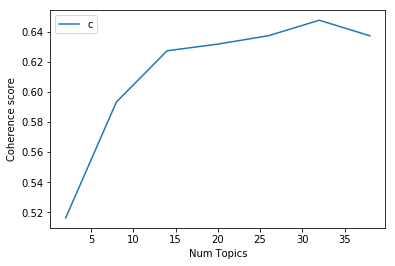

In [38]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5162
Num Topics = 8  has Coherence Value of 0.5933
Num Topics = 14  has Coherence Value of 0.6274
Num Topics = 20  has Coherence Value of 0.6318
Num Topics = 26  has Coherence Value of 0.6374
Num Topics = 32  has Coherence Value of 0.6477
Num Topics = 38  has Coherence Value of 0.6373


In [40]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.029*"god" + 0.018*"christian" + 0.010*"people" + 0.009*"bible" + '
  '0.009*"religion" + 0.007*"church" + 0.007*"faith" + 0.007*"man" + '
  '0.007*"word" + 0.007*"law"'),
 (1,
  '0.033*"file" + 0.033*"window" + 0.020*"line" + 0.017*"program" + '
  '0.016*"problem" + 0.010*"write" + 0.010*"set" + 0.010*"read" + '
  '0.010*"change" + 0.009*"error"'),
 (2,
  '0.118*"write" + 0.099*"article" + 0.080*"organization" + 0.078*"line" + '
  '0.036*"host" + 0.025*"university" + 0.024*"nntp_post" + 0.021*"reply" + '
  '0.021*"nntp_posting" + 0.011*"hear"'),
 (3,
  '0.018*"gun" + 0.012*"people" + 0.011*"state" + 0.011*"armenian" + '
  '0.011*"law" + 0.007*"government" + 0.007*"crime" + 0.006*"weapon" + '
  '0.006*"kill" + 0.006*"turkish"'),
 (4,
  '0.025*"drive" + 0.019*"card" + 0.016*"system" + 0.015*"problem" + '
  '0.013*"driver" + 0.013*"scsi" + 0.012*"work" + 0.011*"bit" + 0.010*"mac" + '
  '0.009*"monitor"'),
 (5,
  '0.038*"line" + 0.027*"organization" + 0.023*"_" + 0.018*"ca" + '
 

In [41]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,18.0,0.1726,"car, bike, back, light, drive, turn, good, eng...",From: (wheres my thing) Subject: WHAT car is t...
1,1,4.0,0.2143,"drive, card, system, problem, driver, scsi, wo...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,18.0,0.2497,"car, bike, back, light, drive, turn, good, eng...",From: (Irwin Arnstein) Subject: Re: Recommenda...
3,3,17.0,0.2448,"image, version, display, graphic, server, soft...",From: (Tsung-Kun Chen) Subject: ** Software fo...
4,4,4.0,0.2157,"drive, card, system, problem, driver, scsi, wo...",From: (Don A.B. Lindbergh) Subject: Diamond SS...
5,5,18.0,0.4382,"car, bike, back, light, drive, turn, good, eng...",From: (Robert Loper) Subject: Re: SHO and SC N...
6,6,10.0,0.1806,"organization, line, university, host, nntp_pos...",From: (Kim Richard Man) Subject: SyQuest 44M c...
7,7,10.0,0.1301,"organization, line, university, host, nntp_pos...",From: (Kirtley Wilson) Subject: Mirosoft Offic...
8,8,3.0,0.1699,"gun, people, state, armenian, law, government,...",Subject: Re: Dont more innocents die without t...
9,9,14.0,0.2727,"point, question, reason, make, claim, exist, a...",From: (Jon Livesey) Subject: Re: Genocide is C...


In [42]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7765,"god, christian, people, bible, religion, churc...",From: (Robert Weiss) Subject: [lds] Ricks repl...
1,1.0,0.9691,"file, window, line, program, problem, write, s...",From: (Landon C. Noll) Subject: Reposting: 10t...
2,2.0,0.5212,"write, article, organization, line, host, univ...",From: (Jim De Arras) Subject: Re: BATF/FBI Mur...
3,3.0,0.7325,"gun, people, state, armenian, law, government,...","From: (Serdar Argic) Subject: To be exact, 2.5..."
4,4.0,0.8159,"drive, card, system, problem, driver, scsi, wo...",From: (D. Keith Rice) Subject: Re: Drive/Contr...


In [43]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,18.0,"car, bike, back, light, drive, turn, good, eng...",853.0,0.0754
1,4.0,"drive, card, system, problem, driver, scsi, wo...",421.0,0.0372
2,18.0,"car, bike, back, light, drive, turn, good, eng...",501.0,0.0443
3,17.0,"image, version, display, graphic, server, soft...",550.0,0.0486
4,4.0,"drive, card, system, problem, driver, scsi, wo...",1328.0,0.1174
5,18.0,"car, bike, back, light, drive, turn, good, eng...",181.0,0.0160
6,10.0,"organization, line, university, host, nntp_pos...",510.0,0.0451
7,10.0,"organization, line, university, host, nntp_pos...",542.0,0.0479
8,3.0,"gun, people, state, armenian, law, government,...",579.0,0.0512
9,14.0,"point, question, reason, make, claim, exist, a...",367.0,0.0324
